# Attack pipeline on Diva using a Decision Tree as explainer

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
sys.path.append("../../lime/")
import mlem
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import shuffle
from sklearn import tree
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from mlem.utilities import save_pickle_bz2, load_pickle_bz2

# DATA LOADING AND CONFIGURATION

In [3]:
from mlem.utilities import load_pickle_bz2

data for the attack

In [4]:
BLACK_BOX = load_pickle_bz2("../datasets/diva/BB_NO_CLUSTERING/BB_DATA/diva_rf_noclustering.bz2")
# x_train x_test y_train y_test x_test_clustered y_test_clustered
BLACK_BOX_DATA = np.load("../datasets/diva/BB_NO_CLUSTERING/BB_DATA/diva_rf_noclustering_data_nsamples_5.npz")
# on the version of diva we're using all the features are numeric
CATEGORICAL_FEATURES_MASK = [False for x in BLACK_BOX_DATA['x_train'][0] ]

In [5]:
train_distr = pd.DataFrame(BLACK_BOX_DATA['y_train']).value_counts(normalize=True)
test_distr = pd.DataFrame(BLACK_BOX_DATA['y_test']).value_counts(normalize=True)

In [6]:
print(f"train size = {len(BLACK_BOX_DATA['y_train'])} | test size = {len(BLACK_BOX_DATA['y_test'])} | total size = {len(BLACK_BOX_DATA['y_train']) + len(BLACK_BOX_DATA['y_test'])}")
print(f"train distribution:\n{train_distr}\n")
print(f"test distribution:\n{test_distr}")

train size = 6624 | test size = 2839 | total size = 9463
train distribution:
0    0.737772
1    0.262228
dtype: float64

test distribution:
0    0.737584
1    0.262416
dtype: float64


X and Y are the row to attack

In [7]:
INDEX = 0

In [8]:
X = BLACK_BOX_DATA['x_test_clustered'][INDEX]
Y = BLACK_BOX_DATA['y_test_clustered'][INDEX]

### building the explainer

Training the explainer on the training data of the black box

In [12]:
explainer_training_data = BLACK_BOX_DATA['x_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(CATEGORICAL_FEATURES_MASK) if el], random_state=123)

# Attack Pipeline on a single element

## 1) Creating the local explainer

at the end of this section the important variables will be:
* `local_model` : contains the local model (the ensemble classifier generated by LIME)
* `x_neigh` : contains the neighborhood generated by LIME
* `y_neigh`: contains the classification of `x_neigh` generated by the local_model

This code is contained in the `__get_local_data` function in the mlem code

In [10]:
explanations, lime_models, x_neigh = explainer.explain_instance(X, BLACK_BOX.predict_proba, labels=[0,1], sampling_method="gaussian", num_samples=5000, num_features=len(X))

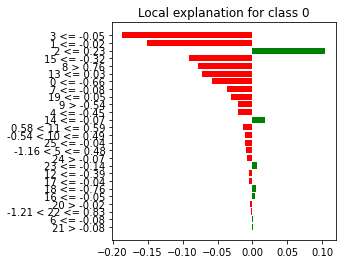

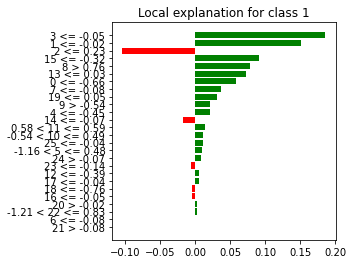

In [11]:
fig0 = explanations.as_pyplot_figure(label=0)
fig1 = explanations.as_pyplot_figure(label=1)

Difference between the points in the neighborhood and the original instance.

*The instances generated by LIME are not very close to the original instance, maybe we could generate neighborhoods in a loop and keep only the closest elements*

In [12]:
from mlem.utilities import norm_nocategorical
difference_from_X_cat = [np.linalg.norm(x_neigh[0]-x) for x in x_neigh]
difference_from_X_nocat = [norm_nocategorical(x_neigh[0]-x, CATEGORICAL_FEATURES_MASK) for x in x_neigh]
print(f"with cat:\tmax = {max(difference_from_X_cat[1:]):.2f} min = {min(difference_from_X_cat[1:]):.2f} avg = {np.average(difference_from_X_cat[1:]):.2f} std= {np.std(difference_from_X_cat[1:]):.2f}")
print(f"without cat:\tmax = {max(difference_from_X_nocat[1:]):.2f} min = {min(difference_from_X_nocat[1:]):.2f} avg = {np.average(difference_from_X_nocat[1:]):.2f} std= {np.std(difference_from_X_nocat[1:]):.2f}")

with cat:	max = 20.66 min = 2.22 avg = 5.80 std= 1.77
without cat:	max = 20.66 min = 2.22 avg = 5.80 std= 1.77


Creating the local model as ensamble of the models returned by lime

In [13]:
attack_dataset = pd.DataFrame(x_neigh)
attack_dataset['Target'] = BLACK_BOX.predict(attack_dataset.to_numpy())

In [14]:
attack_dataset.Target.value_counts()

0    4593
1     407
Name: Target, dtype: int64

In [13]:
def generate_balanced_dataset(x, num_samples, black_box, explainer, max_tries=15, shuffle=True, verbose=False):
    generated = pd.DataFrame(explainer.data_inverse(x, num_samples, 'gaussian')[1])
    generated['Target'] = black_box.predict(generated.to_numpy())
    min_class =-np.NINF
    final = pd.DataFrame()
    for t in range(max_tries):
        if verbose:
            print(f"try number {t}")
        
        if len(final) >= num_samples:
            
            return final.sample(frac=1) if shuffle else final
        
        generated = pd.DataFrame(explainer.data_inverse(x, num_samples, 'gaussian')[1])
        generated['Target'] = black_box.predict(generated.to_numpy())
        
        zeroes = generated[generated['Target'] == 0]
        ones   = generated[generated['Target'] == 1]
        
        if len(zeroes) == 0 or len(ones) == 0:
            continue
        
        if len(final) < num_samples:
            min_len = min(len(zeroes), len(ones))
            final = pd.concat([final, zeroes.head(min_len).copy(), ones.head(min_len).copy()])
    
        if verbose:
            p0, p1 = final.Target.value_counts(normalize=True)
            print(f"{len(final)=} {p0=} {p1=}")
        
        
    raise Exception("Could not generate balanced dataset")


In [16]:
#g = generate_balanced_dataset(X, 5000, BLACK_BOX, explainer, 20, True, True)

In [17]:
#g.to_csv("diva_lime_generated_around_0.csv", index=False)

In [18]:
generated_dataset = pd.read_csv("diva_lime_generated_around_0.csv")

In [19]:
ATTACK_DATASET = generated_dataset.copy()

In [20]:
ATTACK_DATASET

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Target
0,1.518260,0.550878,1.293706,-0.049350,-0.000011,0.477425,0.000001,0.518237,1.181681,0.000000,...,1.611936,-0.243428,-2.599611,-0.026422,0.000000,0.828543,0.000000,-0.183626,-0.000001,0
1,-0.000011,1.568210,-0.118767,-0.046192,-0.000011,-1.209081,0.000001,-0.077592,-0.431329,0.000000,...,-0.038690,-1.606713,-1.839627,-0.026466,0.000000,-0.000022,0.000000,-0.173819,-0.000001,0
2,-0.000011,-0.014742,-0.281302,-0.050877,0.087451,0.477425,0.000001,2.254914,1.068677,0.000000,...,1.483184,-0.162077,-0.070226,-0.025789,0.000000,0.828543,0.000000,-0.213082,-0.000001,0
3,-0.000011,-1.967800,2.143356,-0.041324,1.705630,0.477425,2.773158,-0.068958,1.621821,0.000000,...,-0.038045,0.401027,0.164120,1.276285,0.000000,0.828543,0.000000,-0.212144,-0.000001,1
4,-0.000011,-0.016111,-0.582155,-0.053722,1.069255,-1.264098,1.370225,-0.067236,0.630806,0.000000,...,3.441708,-1.564372,-1.563356,-0.026162,1.863259,0.828543,4.304803,1.382796,-0.000001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5549,-0.000011,3.569423,-1.094050,-0.050422,-0.000011,-1.273831,0.000001,2.340201,0.557249,1.843203,...,-0.036670,1.727552,0.561783,-0.026285,0.000000,-0.000022,0.000000,-0.207784,-0.000001,0
5550,-0.000011,-0.018097,-0.089324,6.996741,-0.000011,-1.178179,0.000001,-0.075297,-1.967313,0.000000,...,-0.036215,-0.197825,0.237145,-0.026153,0.372477,0.828543,4.082327,-0.209003,-0.000001,0
5551,-0.000011,-1.601152,-0.204583,-0.052233,-0.000011,0.477425,3.688038,5.765174,0.669428,0.000000,...,-0.037867,0.132109,0.231229,-0.026406,2.700393,0.828543,0.000000,-0.169674,-0.000001,1
5552,-0.000011,-3.729074,0.163044,-0.052548,-0.000011,0.477425,0.000001,-0.086144,-0.100130,0.000000,...,0.558164,0.384359,0.164071,2.033551,4.513393,0.828543,0.000000,-0.144984,-0.000001,1


In [17]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "criterion": ["gini", "entropy"],
}

def create_decision_tree(
        x_train,
        y_train,
        hyperparameters = __HYPERPARAMETERS,
        n_jobs=4,
        use_halving=True
):
    """Creates a random forest classifier via grid search.

    Args:
        x_train (ndarray): Training input examples.
        y_train (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)
        use_halving (bool): If true use the HalvingGridSearch

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    dt = tree.DecisionTreeClassifier()

    if use_halving:
        clf = HalvingGridSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    else:
        clf = RandomizedSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x_train, y_train)
    # print(f"GRID_SEARCH BEST PARAMS: {clf.best_params_=}")
    return clf.best_estimator_

In [22]:
X_train, X_test, y_train, y_test = train_test_split(generated_dataset.drop('Target', axis=1).to_numpy(), generated_dataset.Target.to_numpy(), test_size=0.33, random_state=42)

In [23]:
dt = create_decision_tree(X_train, y_train, use_halving=True) if not Path("decision_tree_diva_91.bz2").exists() else load_pickle_bz2("decision_tree_diva_91.bz2")

In [24]:
dt

DecisionTreeClassifier(criterion='entropy')

The decision tree has good performances

In [25]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       903
           1       0.91      0.90      0.91       930

    accuracy                           0.91      1833
   macro avg       0.91      0.91      0.91      1833
weighted avg       0.91      0.91      0.91      1833



Black Box

In [26]:
print(classification_report(y_test, BLACK_BOX.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       930

    accuracy                           1.00      1833
   macro avg       1.00      1.00      1.00      1833
weighted avg       1.00      1.00      1.00      1833



In [27]:
pd.DataFrame(y_test).value_counts()

1    930
0    903
dtype: int64

In [28]:
if not Path("decision_tree_diva_91.bz2").exists():
    save_pickle_bz2("decision_tree_diva_91.bz2", dt)
    np.savez("decision_tree_diva_91.data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Attacking the decision tree

In [29]:
from mlem.shadow_models import ShadowModelsManager

Reloading the tree and its data

In [30]:
local_tree = load_pickle_bz2("decision_tree_diva_91.bz2")
loaded     = np.load("decision_tree_diva_91.data.npz", allow_pickle=True)

In [31]:
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']
full_generated_dataset = pd.read_csv("diva_lime_generated_around_0.csv")

Using the lime generated dataset as x_attack and the labels computed by the dt as y_attack

In [32]:
x_attack = full_generated_dataset.drop('Target', axis=1)
y_attack = local_tree.predict(x_attack.to_numpy())

Comparing the local_tree predictions to the "real" label

In [33]:
(y_attack == full_generated_dataset.Target).value_counts(normalize=True)

True     0.969031
False    0.030969
Name: Target, dtype: float64

### with Adaboost

using adaboost for the ShadowModels

In [34]:
from mlem.utilities import create_adaboost

path="DT/shadow_adab_diva_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_adaboost,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [35]:
shadow_models.fit(x_attack, y_attack)

In [36]:
attack_dataset = shadow_models.get_attack_dataset()
attack_dataset

,0,1,label,inout
0,0.520177,0.479823,0,in
1,0.496611,0.503389,1,in
2,0.512690,0.487310,0,in
3,0.489404,0.510596,1,in
4,0.500423,0.499577,0,in
...,...,...,...,...
2772,0.526098,0.473902,0,out
2773,0.504735,0.495265,1,out
2774,0.477020,0.522980,1,out
2775,0.512973,0.487027,0,out


The mean and std are close to 0.5 and 0

In [37]:
attack_dataset[attack_dataset.label == 0][[0,1]].describe()

,0,1
count,11140.000000,11140.000000
mean,0.523374,0.476626
std,0.018418,0.018418
min,0.422262,0.408734
25%,0.509682,0.464758
50%,0.522087,0.477913
75%,0.535242,0.490318
max,0.591266,0.577738


In [38]:
attack_dataset[attack_dataset.label == 1][[0,1]].describe()

,0,1
count,11108.000000,11108.000000
mean,0.484416,0.515584
std,0.012165,0.012165
min,0.375225,0.458040
25%,0.478117,0.507716
50%,0.485845,0.514155
75%,0.492284,0.521883
max,0.541960,0.624775


In [39]:
attack_dataset_ins = attack_dataset[attack_dataset.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs = attack_dataset[attack_dataset.inout == 'out']#.drop('inout', axis=1)

In [40]:
int_df = pd.merge(attack_dataset_ins, attack_dataset_outs, how ='inner', on =[0, 1])

**These probability distributions appear both with the label in and out in the attack dataset**

In [41]:
int_df

,0,1,label_x,inout_x,label_y,inout_y
0,0.375225,0.624775,1,in,1,out
1,0.375225,0.624775,1,in,1,out
2,0.375225,0.624775,1,in,1,out
3,0.375225,0.624775,1,in,1,out
4,0.375225,0.624775,1,in,1,out
...,...,...,...,...,...,...
152,0.475877,0.524123,1,in,1,out
153,0.463786,0.536214,1,in,1,out
154,0.485662,0.514338,1,in,1,out
155,0.487894,0.512106,1,in,1,out


Creating the attack model for each label using Adaboost

In [42]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
attack_models = AttackModelsManager(
        results_path=f"DT/attack_adab_diva_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [43]:
attack_models.fit(attack_dataset)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


Loading the attack models just created

In [44]:
atk_0 = load_pickle_bz2("DT/attack_adab_diva_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_adab_diva_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [33]:
def attack_bb_dataset(atk_0, atk_1, bb_data=BLACK_BOX_DATA):
    
    # extracting train and test set of the BB
    BB_TRAIN = pd.DataFrame(bb_data['x_train'])
    BB_TRAIN['Target'] = bb_data['y_train']

    BB_TEST = pd.DataFrame(bb_data['x_test'])
    BB_TEST['Target'] = bb_data['y_test']
    
    # for each set separate the elements belonging to class 0 from the ones of class 1
    BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
    BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

    BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
    BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]
    
    # use the black box to compute the probabilities
    BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
    BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))
    
    # use the attack models
    BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
    BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
    
    BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
    BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())
    
    # assign the true label to each element so that it can be easily compared to the one from the attack model
    BB_TEST_0['Y'] = 'out'
    BB_TEST_1['Y'] = 'out'
    BB_TRAIN_0['Y'] = 'in'
    BB_TRAIN_1['Y'] = 'in'
    
    # concatenate everything
    train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])
    return train_test

In [69]:
def attack_dataset(atk_0, atk_1, train, test):
    
    # extracting train and test set of the BB
    BB_TRAIN = train

    BB_TEST = test
    
    # for each set separate the elements belonging to class 0 from the ones of class 1
    BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
    BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

    BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
    BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]
    
    # use the black box to compute the probabilities
    BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
    BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))
    
    # use the attack models
    BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
    BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
    
    BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
    BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())
    
    # assign the true label to each element so that it can be easily compared to the one from the attack model
    BB_TEST_0['Y'] = 'out'
    BB_TEST_1['Y'] = 'out'
    BB_TRAIN_0['Y'] = 'in'
    BB_TRAIN_1['Y'] = 'in'
    
    # concatenate everything
    train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])
    return train_test

In [46]:
train_test = attack_bb_dataset(atk_0, atk_1)

In [47]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.71      0.75      0.73      6624
         out       0.32      0.27      0.29      2839

    accuracy                           0.61      9463
   macro avg       0.51      0.51      0.51      9463
weighted avg       0.59      0.61      0.60      9463



In [48]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     2060
out     779
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f747b44ac40>


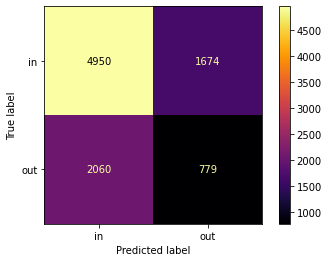

In [49]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Let's see the behavior on the points closest to the instance used to create the neighborhood

In [70]:
import scipy.spatial.distance as distance

The distance column contains the distance from the point used to generate the neighborhood

In [71]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [72]:
BB_DATA_TR.Distance.describe()

count    6624.000000
mean        4.487911
std         4.081426
min         0.181771
25%         3.329167
50%         4.255069
75%         5.112993
max       124.664422
Name: Distance, dtype: float64

In [73]:
BB_DATA_TE.Distance.describe()

count    2839.000000
mean        4.443655
std         3.768543
min         0.000000
25%         3.352572
50%         4.233015
75%         5.119664
max       108.097071
Name: Distance, dtype: float64

In [74]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 2.5])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 3])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 2.5])=606
len(BB_DATA_TE[BB_DATA_TE.Distance < 3])=504


In [75]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

1    0.569307
0    0.430693
Name: Target, dtype: float64

In [76]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

1    0.553571
0    0.446429
Name: Target, dtype: float64

Creating the dataset with the closest points

In [77]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [82]:
train_test_close = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [83]:
print(classification_report(train_test_close.Y, train_test_close.ATK))

              precision    recall  f1-score   support

          in       0.55      0.43      0.48       606
         out       0.46      0.57      0.51       504

    accuracy                           0.50      1110
   macro avg       0.50      0.50      0.50      1110
weighted avg       0.51      0.50      0.49      1110



In [84]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     2060
out     779
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f747b8c8550>


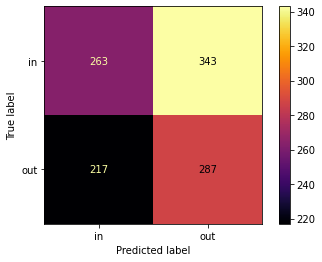

In [85]:
ConfusionMatrixDisplay.from_predictions(train_test_close.Y, train_test_close.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [86]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=85
len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=32


In [87]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [88]:
train_test_closer_1 = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [89]:
print(classification_report(train_test_closer_1.Y, train_test_closer_1.ATK))

              precision    recall  f1-score   support

          in       0.68      0.25      0.36        85
         out       0.26      0.69      0.37        32

    accuracy                           0.37       117
   macro avg       0.47      0.47      0.37       117
weighted avg       0.56      0.37      0.37       117



In [90]:
train_test_closer_1[train_test_closer_1.Y == 'out'].ATK.value_counts()

out    22
in     10
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f747b4ba430>


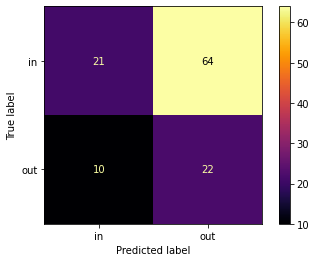

In [91]:
ConfusionMatrixDisplay.from_predictions(train_test_closer_1.Y, train_test_closer_1.ATK, cmap='inferno')

### with a nn instead of Adaboost

In [92]:
from mlem.utilities import create_nn_model_keras

path="DT/shadow_nn_diva_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_nn_model_keras,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [ ]:
shadow_models.fit(x_attack, y_attack)

In [94]:
attack_dataset_nn = shadow_models.get_attack_dataset()
attack_dataset_nn

,0,1,label,inout
0,0.364857,0.635143,0,in
1,0.858356,0.141644,0,in
2,0.969342,0.030658,0,in
3,0.774840,0.225160,0,in
4,0.034781,0.965219,1,in
...,...,...,...,...
2772,0.582857,0.417143,0,out
2773,0.147151,0.852849,0,out
2774,0.488974,0.511026,1,out
2775,0.156228,0.843772,1,out


In [95]:
attack_dataset_nn[attack_dataset_nn.label == 0][[0,1]].describe()

,0,1
count,11140.000000,1.114000e+04
mean,0.696875,3.031250e-01
std,0.283754,2.837536e-01
min,0.002400,5.830083e-07
25%,0.489110,5.168779e-02
50%,0.786476,2.135237e-01
75%,0.948312,5.108899e-01
max,0.999999,9.976000e-01


In [96]:
attack_dataset_nn[attack_dataset_nn.label == 1][[0,1]].describe()

,0,1
count,11108.000000,11108.000000
mean,0.271536,0.728464
std,0.227222,0.227222
min,0.000168,0.001407
25%,0.097881,0.610115
50%,0.199851,0.800149
75%,0.389885,0.902119
max,0.998593,0.999832


In [97]:
attack_dataset_nn[attack_dataset_nn.inout == 'in'][[0,1]].describe()

,0,1
count,11140.000000,11140.000000
mean,0.484230,0.515770
std,0.335890,0.335890
min,0.000168,0.000001
25%,0.164996,0.176910
50%,0.431444,0.568556
75%,0.823090,0.835004
max,0.999999,0.999832


In [98]:
attack_dataset_nn[attack_dataset_nn.inout == 'out'][[0,1]].describe()

,0,1
count,11108.000000,1.110800e+04
mean,0.484794,5.152063e-01
std,0.331399,3.313992e-01
min,0.000388,5.830083e-07
25%,0.173281,1.862122e-01
50%,0.431712,5.682881e-01
75%,0.813788,8.267185e-01
max,0.999999,9.996120e-01


In [99]:
attack_dataset_ins_nn = attack_dataset_nn[attack_dataset_nn.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs_nn = attack_dataset_nn[attack_dataset_nn.inout == 'out']#.drop('inout', axis=1)

Creating the attack models for each label **using Adaboost**

In [100]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
from mlem.utilities import create_adaboost

attack_models = AttackModelsManager(
        results_path=f"DT/attack_nn_diva_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [101]:
attack_dataset_nn

,0,1,label,inout
0,0.364857,0.635143,0,in
1,0.858356,0.141644,0,in
2,0.969342,0.030658,0,in
3,0.774840,0.225160,0,in
4,0.034781,0.965219,1,in
...,...,...,...,...
2772,0.582857,0.417143,0,out
2773,0.147151,0.852849,0,out
2774,0.488974,0.511026,1,out
2775,0.156228,0.843772,1,out


In [102]:
attack_models.fit(attack_dataset_nn)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


In [103]:
atk_0 = load_pickle_bz2("DT/attack_nn_diva_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_nn_diva_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [104]:
train_test = attack_bb_dataset(atk_0, atk_1)

In [105]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.80      0.75      6624
         out       0.32      0.22      0.26      2839

    accuracy                           0.62      9463
   macro avg       0.51      0.51      0.50      9463
weighted avg       0.59      0.62      0.60      9463



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f72e978bbe0>


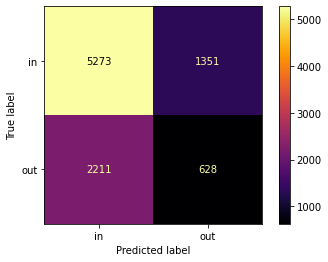

In [106]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

In [107]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     2211
out     628
Name: ATK, dtype: int64

Let's see on the points closest to the instance used to create the neighborhood

In [108]:
import scipy.spatial.distance as distance

In [58]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [59]:
BB_DATA_TR.Distance.describe()

count    6624.000000
mean        4.487911
std         4.081426
min         0.181771
25%         3.329167
50%         4.255069
75%         5.112993
max       124.664422
Name: Distance, dtype: float64

In [60]:
BB_DATA_TE.Distance.describe()

count    2839.000000
mean        4.443655
std         3.768543
min         0.000000
25%         3.352572
50%         4.233015
75%         5.119664
max       108.097071
Name: Distance, dtype: float64

In [61]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

1    0.569307
0    0.430693
Name: Target, dtype: float64

In [62]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

1    0.553571
0    0.446429
Name: Target, dtype: float64

Creating the dataset with the closest points

In [63]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [109]:
train_test_close = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [110]:
print(classification_report(train_test_close.Y, train_test_close.ATK))

              precision    recall  f1-score   support

          in       0.72      0.65      0.68        85
         out       0.27      0.34      0.30        32

    accuracy                           0.56       117
   macro avg       0.50      0.50      0.49       117
weighted avg       0.60      0.56      0.58       117



In [111]:
train_test_close[train_test_close.Y == 'out'].ATK.value_counts()

in     21
out    11
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f72e8f55550>


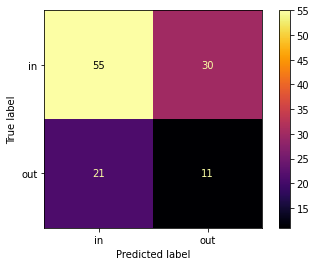

In [112]:
ConfusionMatrixDisplay.from_predictions(train_test_close.Y, train_test_close.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [113]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=85
len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=32


In [114]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [115]:
train_test_closer_1 = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [116]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.80      0.75      6624
         out       0.32      0.22      0.26      2839

    accuracy                           0.62      9463
   macro avg       0.51      0.51      0.50      9463
weighted avg       0.59      0.62      0.60      9463



In [117]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     2211
out     628
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fedd0ee5730>


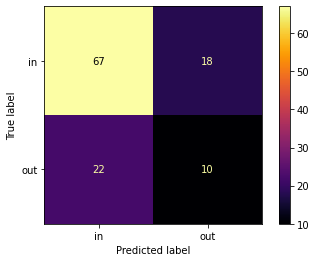

In [82]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

# Attack on the whole dataset

In [7]:
x_atk_dataset = BLACK_BOX_DATA['x_test_clustered']
y_atk_dataset = BLACK_BOX_DATA['y_test_clustered']

In [9]:
print(f"{len(x_atk_dataset)=} {len(y_atk_dataset)=}")

len(x_atk_dataset)=40 len(y_atk_dataset)=40


### Run the attack for each row

In [15]:
OUTPUT_ATTACK_FULL_FOLDER = Path("DIVA_ATTACK_DT_FULL")
#OUTPUT_ATTACK_FULL_FOLDER.mkdir(exist_ok=True)

Generate the data for the attack using LIME and the black box and save it

Splitting the generated data in train/test and building the decision trees

In [22]:
for i in range(len(x_atk_dataset)):
    p = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "lime_generated.csv"
    gen_dataset = pd.read_csv(p)
    # splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(gen_dataset.drop('Target', axis=1).to_numpy(), gen_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    # creating the decision tree
    dt_path = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "dt_diva.bz2"
    dt = create_decision_tree(X_train, y_train, use_halving=True) if not dt_path.exists() else load_pickle_bz2(dt_path)
    print(f"DT #{i}")
    print(classification_report(y_test, dt.predict(X_test)))
    if not dt_path.exists():
        save_pickle_bz2(dt_path, dt)
        np.savez(str(OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "dt_diva_data.npz"), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

DT #0
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       862
           1       0.89      0.90      0.90       876

    accuracy                           0.90      1738
   macro avg       0.90      0.90      0.90      1738
weighted avg       0.90      0.90      0.90      1738

DT #1
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       934
           1       0.92      0.93      0.92       885

    accuracy                           0.92      1819
   macro avg       0.92      0.92      0.92      1819
weighted avg       0.92      0.92      0.92      1819

DT #2
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       890
           1       0.90      0.91      0.91       910

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800

D

## Attacking every decision tree

In [26]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

Reloading the tree and its data

Loading the attack models just created

In [55]:
attacks_0 = []
attacks_1 = []
for i in range(len(x_atk_dataset)):
    p = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "attack_adab_diva_dt"
    atk_0 = load_pickle_bz2( p/ "0" / "model.pkl.bz2")
    atk_1 = load_pickle_bz2( p/ "1" / "model.pkl.bz2")
    attacks_0.append(atk_0)
    attacks_1.append(atk_1)

Creating the ensemble classifiers

In [56]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier

In [57]:
ens_0 = HardVotingClassifier(attacks_0)
ens_1 = HardVotingClassifier(attacks_1)

Attacking the black box dataset

In [58]:
train_test = attack_bb_dataset(ens_0, ens_1)

In [59]:
t2 = train_test[train_test.ATK != 'even']

In [60]:
print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.72      0.26      0.38      6543
         out       0.31      0.76      0.44      2803

    accuracy                           0.41      9346
   macro avg       0.51      0.51      0.41      9346
weighted avg       0.60      0.41      0.40      9346



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fbf8c56a9a0>


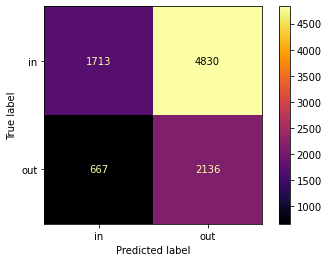

In [61]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

In [62]:
ens_0s = SoftVotingClassifier(attacks_0)
ens_1s = SoftVotingClassifier(attacks_1)

In [63]:
train_test = attack_bb_dataset(ens_0s, ens_1s)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.72      0.25      0.37      6624
         out       0.31      0.77      0.44      2839

    accuracy                           0.41      9463
   macro avg       0.51      0.51      0.41      9463
weighted avg       0.60      0.41      0.39      9463



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fbf8c4d0190>


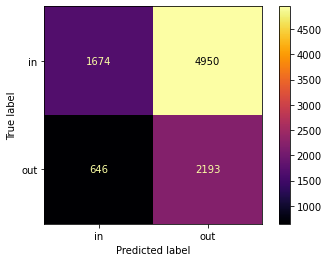

In [64]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

In [65]:
ens_0k = KMostSureVotingClassifier(attacks_0)
ens_1k = KMostSureVotingClassifier(attacks_1)

In [66]:
train_test = attack_bb_dataset(ens_0k, ens_1k)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.72      0.25      0.37      6624
         out       0.31      0.77      0.44      2839

    accuracy                           0.41      9463
   macro avg       0.51      0.51      0.41      9463
weighted avg       0.60      0.41      0.39      9463



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fbf8c4fe520>


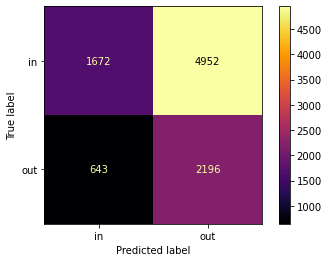

In [67]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')